In [1]:
!pip install fredapi > /dev/null
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import yfinance as yf
from fredapi import Fred
fred_key='e5a9aa45ccc6a9d379d7531e373f67bb'
fred = Fred(api_key=fred_key)

The system cannot find the path specified.


### Get data

In [2]:
# Data from excel
fx = pd.read_excel('fx.xlsx', index_col='date', parse_dates=True)
ppp_dev = pd.read_excel('ppp.xlsx', sheet_name='dev_oos', index_col='date', parse_dates=True)
cpi_fcst = pd.read_excel('WEO_forecasts.xlsx',sheet_name='cpi', index_col='date', parse_dates=True)
gdp_fcst = pd.read_excel('WEO_forecasts.xlsx',sheet_name='cpi', index_col='date', parse_dates=True)
# Forecasts relative to the US
cpi_diff = cpi_fcst.sub(cpi_fcst['USD'], axis=0)
gdp_diff = gdp_fcst.sub(gdp_fcst['USD'], axis=0)
# PPP data from monthly to quarterly
ppp_dev = ppp_dev.resample('Q').agg(lambda x: x[-1])

In [3]:
# Pull rates data from the FRED website
all_results = []
rates_codes = ['IR3TIB01EZQ156N','IR3TIB01JPQ156N','IR3TIB01GBQ156N','IR3TIB01CNQ156N',
               'IR3TIB01AUQ156N','IR3TIB01CAQ156N','IR3TIB01CHQ156N','IR3TIB01SEQ156N',
               'IR3TIB01KRQ156N','IR3TIB01NOQ156N','IR3TIB01NZQ156N','INDIR3TIB01STQ',
               'IR3TIB01MXQ156N','IR3TIB01ZAQ156N','IR3TIB01PLQ156N','IR3TIB01ILQ156N',
               'IR3TIB01IDQ156N','IR3TIB01CZQ156N','IR3TIB01TRQ156N','IR3TIB01HUQ156N',
               'IR3TIB01CLQ156N','IR3TIB01RUQ156N','IR3TIB01USQ156N','IR3TIB01DEQ156N',
               'IR3TIB01FRQ156N','IR3TIB01ITQ156N','IR3TIB01ESQ156N','IR3TIB01DKQ156N']
for myid in rates_codes:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    time.sleep(0.1)
rates_results = pd.concat(all_results, axis=1)
rates = rates_results[rates_results.index >= '1980-01-01']
rates = rates.resample('Q').agg(lambda x: x[-1])

# Change rate tickers
id_dict = {'IR3TIB01EZQ156N':'EUR','IR3TIB01JPQ156N':'JPY','IR3TIB01GBQ156N':'GBP',
           'IR3TIB01CNQ156N':'CNY','IR3TIB01AUQ156N':'AUD','IR3TIB01CAQ156N':'CAD',
           'IR3TIB01CHQ156N':'CHF','IR3TIB01SEQ156N':'SEK','IR3TIB01KRQ156N':'KRW',
           'IR3TIB01NOQ156N':'NOK','IR3TIB01NZQ156N':'NZD','INDIR3TIB01STQ':'INR',
           'IR3TIB01MXQ156N':'MXN','IR3TIB01ZAQ156N':'ZAR','IR3TIB01PLQ156N':'PLN',
           'IR3TIB01ILQ156N':'ILS','IR3TIB01IDQ156N':'IDR','IR3TIB01CZQ156N':'CZK',
           'IR3TIB01TRQ156N':'TRY','IR3TIB01HUQ156N':'HUF','IR3TIB01CLQ156N':'CLP',
           'IR3TIB01RUQ156N':'RUB','IR3TIB01USQ156N':'USD','IR3TIB01DEQ156N':'DEM',
           'IR3TIB01FRQ156N':'FRF','IR3TIB01ITQ156N':'ITL','IR3TIB01ESQ156N':'ESP',
           'IR3TIB01DKQ156N':'DKK'}
rates.columns = [id_dict[c] for c in rates.columns]

# Append brazil data
br_rates = fred.get_series('INTGSTBRM193N')
br_rates = br_rates.to_frame(name='BRL')
br_rates = br_rates.resample('Q').agg(lambda x: x[-1])
rates = pd.concat([rates, br_rates], axis=1)

In [4]:
# Get BIS policy rate data and clean it
    # Go to: https://data.bis.org/bulkdownload
    # Download: Central bank policy rates (CVS, flat)
    # Save in same folder as code
prate = pd.read_csv(r'WS_CBPOL_csv_flat.csv')
prate = prate[prate['FREQ:Frequency'].str.startswith('M')]
countries = ['US', 'XM', 'JP', 'GB', 'CN', 'AU', 'CA', 'CH', 'HK', 'SG', 'SE', 'KR', 'NO',
             'NZ', 'IN', 'MX', 'ZA', 'BR', 'DK', 'PL', 'TH', 'IL', 'ID', 'CZ', 'AE', 'TR',
             'HU', 'CL', 'SA', 'PH', 'MY', 'CO', 'RU', 'RO', 'PE', 'DE', 'FR', 'IT', 'ES']
prate = prate[prate['REF_AREA:Reference area'].str[:2].isin(countries)]
columns_to_keep = ['REF_AREA:Reference area', 
                   'TIME_PERIOD:Time period or range', 'OBS_VALUE:Observation Value']
prate = prate[columns_to_keep]
prate = prate.reset_index(drop=True)
prate = prate.rename(columns={'REF_AREA:Reference area': 'country',
                              'TIME_PERIOD:Time period or range': 'date',
                              'OBS_VALUE:Observation Value': 'prate'})
prate['country'] = prate['country'].str[:2]
currency_mapping = {'US':'USD','XM':'EUR','JP':'JPY','GB':'GBP','CN':'CNY','AU':'AUD',
                    'CA':'CAD','CH':'CHF','HK':'HKD','SG':'SGD','SE':'SEK','KR':'KRW',
                    'NO':'NOK','NZ':'NZD','IN':'INR','MX':'MXN','TW':'TWD','ZA':'ZAR',
                    'BR':'BRL','DK':'DKK','PL':'PLN','TH':'THB','IL':'ILS','ID':'IDR',
                    'CZ':'CZK','AE':'AED','TR':'TRY','HU':'HUF','CL':'CLP','SA':'SAR',
                    'PH':'PHP','MY':'MYR','CO':'COP','RU':'RUB','RO':'RON','PE':'PEN',
                    'DE':'DEM','FR':'FRF','IT':'ITL','ES':'ESP'}
prate['currency'] = prate['country'].map(currency_mapping)
prate['date'] = pd.to_datetime(prate['date'])
prate.set_index('date', inplace=True)
prate = prate.pivot_table(index='date', columns='currency', values='prate')
prate = prate[prate.index.year >= 1980]
prate.index = prate.index + pd.offsets.MonthEnd(0)

C:\Users\educh\AppData\Local\Temp\ipykernel_47992\3754436450.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  prate = pd.read_csv(r'WS_CBPOL_csv_flat.csv')


In [5]:
# Change frequency to quarterly
prate = prate.resample('Q').last()
fx_q = fx.resample('Q').last()

In [6]:
# Combine rate dataframes
mask = ~rates.isna()
prate[mask] = rates[mask]
# Do not invest when rates > 15%
rates_q = prate.mask((prate > 15), np.nan)
# Calculate risk free rate (USD)
rf = prate['USD'].shift(1)/4

### Trading Strategy

In [7]:
# Country groups
dm = ['EUR','JPY','GBP','AUD','CAD','CHF','SEK','NOK','NZD']
em = ['CNY','KRW','INR','MXN','ZAR','BRL','PLN','THB','ILS','IDR','CZK','TRY','HUF','CLP',
      'PHP','MYR','COP','RUB','RON','PEN']
core = ['EUR','JPY','GBP','AUD','CAD','CHF','SEK','NOK','NZD','CNY','KRW','INR','MXN','ZAR','BRL',
        'PLN','THB','ILS','IDR','CZK','TRY','HUF','CLP','PHP','MYR','COP','RUB','RON','PEN']

In [8]:
# FX forecast (for next year)
fx_fcst = pd.DataFrame()
fx_fcst[dm] = (- 0.5/3 * ppp_dev[dm] - cpi_diff[dm])
fx_fcst[em] = (- cpi_diff[em])
# Total return forecast (for next quarter)
tr_fcst = ((1+rates_q/400)*(1+fx_fcst/400)-1)*100

In [9]:
# Calculate total returns
fx_inv = 1 / fx_q
fx_ret = fx_inv.pct_change()*100
rates_ret = rates_q.shift(1)/4
tr = ((1+rates_ret/100)*(1+fx_ret/100)-1)*100
tr_usd = tr.add(-rf, axis=0)

In [10]:
# Function to assign 1 to the top 1/3 of countries and -1 to the bottom 1/3 of countries
def assign_labels(row):
    non_nan_countries = row.dropna()
    if non_nan_countries.empty:
        return pd.Series(np.nan, index=row.index)
    else:
        threshold = int((len(non_nan_countries) / 3))
        top_countries = non_nan_countries.nlargest(threshold).index
        bottom_countries = non_nan_countries.nsmallest(threshold).index
        labels = pd.Series(0, index=row.index, dtype=int)
        labels[top_countries] = 1
        labels[bottom_countries] = -1
        return labels

In [11]:
# Apply the function to create the trading signals
signals = tr_fcst[core].apply(assign_labels, axis=1)

signals2 = rates_q[core].apply(assign_labels, axis=1)

In [12]:
# Assign weights to trading signals
leverage = 1
positions = signals.abs().sum(axis=1)/2
weights = leverage * signals.div(positions, axis=0)

positions2 = signals2.abs().sum(axis=1)/2
weights2 = leverage * signals2.div(positions2, axis=0)

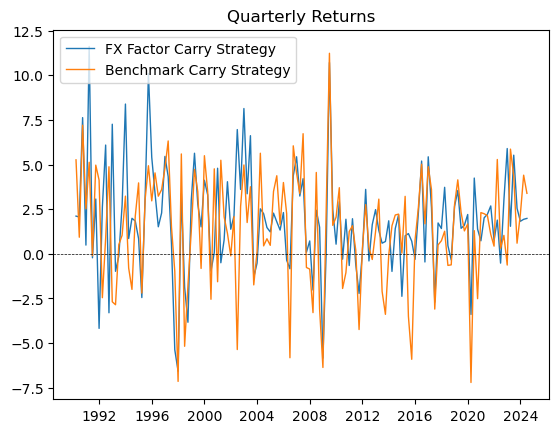

In [13]:
# Calculate quarterly portfolio returns
weighted_tr = weights.shift(1) * tr[core]
strategy_tr = weighted_tr.sum(axis=1)
portfolio_tr = strategy_tr['1990':] + rf['1990':]

weighted_tr2 = weights2.shift(1) * tr_usd[core]
strategy_tr2 = weighted_tr2.sum(axis=1)
portfolio_tr2 = strategy_tr2['1990':] + rf['1990':]

plt.plot(portfolio_tr, label="FX Factor Carry Strategy", lw=1)
plt.plot(portfolio_tr2, label="Benchmark Carry Strategy", lw=1)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.title('Quarterly Returns')
plt.legend()
plt.show()

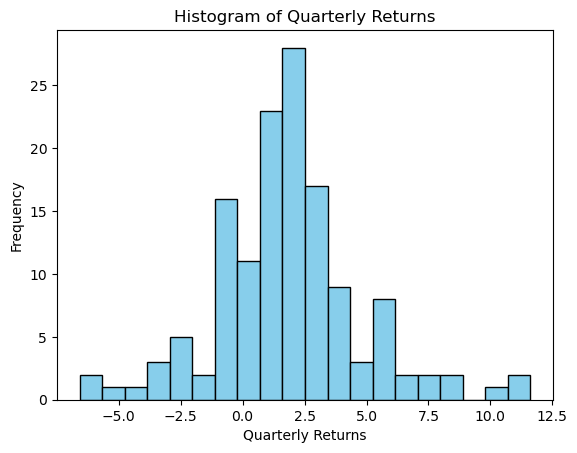

In [14]:
# Plot histogram
plt.hist(portfolio_tr, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Quarterly Returns')
plt.ylabel('Frequency')
plt.title('Histogram of Quarterly Returns')
plt.show()

In [15]:
# Download S&P 500 data from Yahoo Finance
eqmkt = yf.download("^GSPC", start="1980-01-01")['Close'].resample('Q').last()
eqmkt_ret = eqmkt.pct_change()*100
eqmkt_ret = eqmkt_ret['1990':]

[*********************100%%**********************]  1 of 1 completed


In [16]:
# Calculate long-run Sharpe Ratio of strategies
def sharpe_ratio(returns):
    returns = returns.dropna()
    avg_ret = np.mean(returns)*4
    std_dev = np.std(returns)*np.sqrt(4)
    avg_rf = np.mean(rf['1990':].dropna())*4
    sharpe_ratio = (avg_ret - avg_rf) / std_dev
    return avg_ret, avg_rf, std_dev, sharpe_ratio

avg_ret, avg_rf, std_dev, sr = sharpe_ratio(portfolio_tr)
avg_ret2, avg_rf, std_dev2, sr2 = sharpe_ratio(portfolio_tr2)
avg_ret3, avg_rf, std_dev3, sr3 = sharpe_ratio(eqmkt_ret)
avg_ret4, avg_rf, std_dev4, sr4 = sharpe_ratio(rf['1990':].dropna())

In [17]:
# Calculate Wealth Index and Drawdown
def historical_analysis(returns):
    wealth_index = (1 + returns/100).cumprod() * 100
    rolling_max = wealth_index.cummax()
    drawdown = (wealth_index - rolling_max) / rolling_max
    drawdown_duration = drawdown * 0
    for i in range(1, len(drawdown)):
        if drawdown[i] < 0:
            drawdown_duration[i] = drawdown_duration[i-1] + 1
        else:
            drawdown_duration[i] = 0
    max_drawdown = drawdown.min()
    max_duration = drawdown_duration.max()
    return wealth_index, drawdown, max_drawdown, max_duration

wealth_index, drawdown, max_drawdown, max_duration = historical_analysis(portfolio_tr)
wealth_index2, drawdown2, max_drawdown2, max_duration2 = historical_analysis(portfolio_tr2)
wealth_index3, drawdown3, max_drawdown3, max_duration3 = historical_analysis(eqmkt_ret)

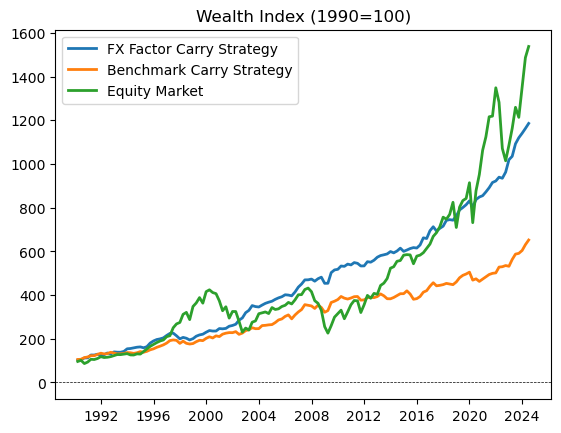

In [18]:
plt.plot(wealth_index, label='FX Factor Carry Strategy', lw=2)
plt.plot(wealth_index2, label='Benchmark Carry Strategy', lw=2)
plt.plot(wealth_index3, label='Equity Market', lw=2)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.title('Wealth Index (1990=100)')
plt.legend()
plt.show()

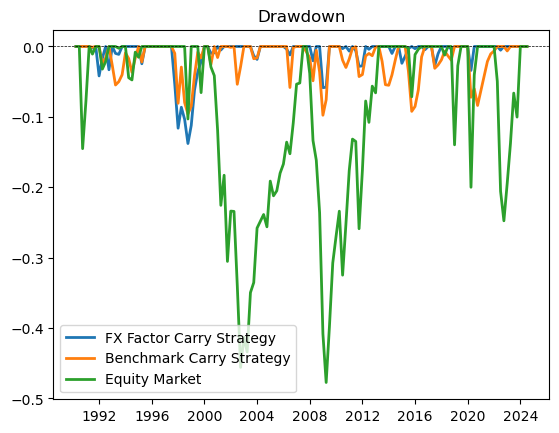

In [19]:
plt.plot(drawdown, label='FX Factor Carry Strategy', lw=2)
plt.plot(drawdown2, label='Benchmark Carry Strategy', lw=2)
plt.plot(drawdown3, label='Equity Market', lw=2)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.title('Drawdown')
plt.legend()
plt.show()

In [20]:
# Correlation and Beta with Equity Market
def corr_beta(returns):
    correlation = returns.corr(eqmkt_ret)
    covariance = returns.cov(eqmkt_ret)
    variance_eqmkt = eqmkt_ret.var()
    beta = covariance / variance_eqmkt
    return correlation, beta

correlation, beta = corr_beta(portfolio_tr)
correlation2, beta2 = corr_beta(portfolio_tr2)
correlation4, beta4 = corr_beta(rf['1990':].dropna())

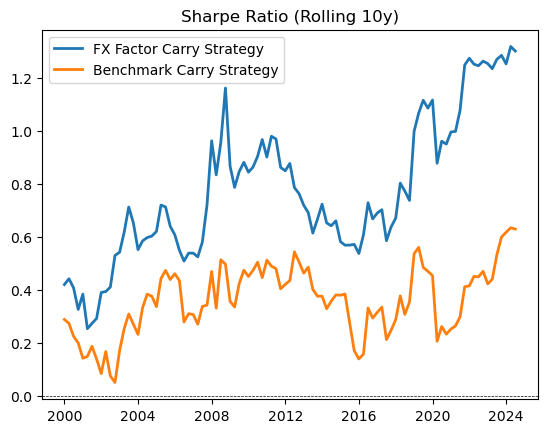

In [21]:
# Calculate rolling 10-year Sharpe ratio
def rolling_sharpe(returns, years):
    ret = returns.rolling(window=years*4).mean()*4
    std = returns.rolling(window=years*4).std()*np.sqrt(4)
    rfr = rf['1990':].rolling(window=years*4).mean()*4
    sr = (ret - rfr) / std
    return(sr)

rolling_10ysr = rolling_sharpe(portfolio_tr,10)
rolling_10ysr2 = rolling_sharpe(portfolio_tr2,10)
rolling_10ysr3 = rolling_sharpe(eqmkt_ret,10)

plt.plot(rolling_10ysr, label='FX Factor Carry Strategy', lw=2)
plt.plot(rolling_10ysr2, label='Benchmark Carry Strategy', lw=2)
#plt.plot(rolling_10ysr3, label='Equity Market', lw=2)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.title('Sharpe Ratio (Rolling 10y)')
plt.legend()
plt.show()

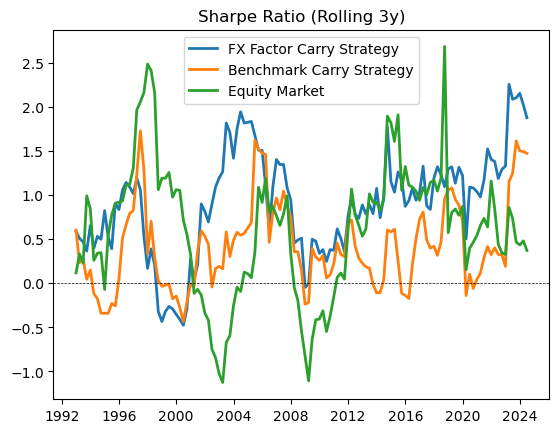

In [22]:
# Calculate rolling 3-year Sharpe ratio
rolling_3ysr = rolling_sharpe(portfolio_tr,3)
rolling_3ysr2 = rolling_sharpe(portfolio_tr2,3)
rolling_3ysr3 = rolling_sharpe(eqmkt_ret,3)

plt.plot(rolling_3ysr, label='FX Factor Carry Strategy', lw=2)
plt.plot(rolling_3ysr2, label='Benchmark Carry Strategy', lw=2)
plt.plot(rolling_3ysr3, label='Equity Market', lw=2)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.title('Sharpe Ratio (Rolling 3y)')
plt.legend()
plt.show()

In [23]:
# Save out-of-sample results in excel
with pd.ExcelWriter('carry_strategy_results.xlsx') as writer:
    signals.to_excel(writer, sheet_name='signals')
    weights.to_excel(writer, sheet_name='weights')
    weighted_tr.to_excel(writer, sheet_name='contributions')
    tr.to_excel(writer, sheet_name='total_return')

In [24]:
def annual_return(returns):
    return (returns / 100 + 1).prod() - 1
annual_tr = portfolio_tr2.resample('A').apply(annual_return) * 100

In [25]:
# Stats table
stats = {
    'Statistic': ['Average return', 'Standard deviation', 'Sharpe ratio (full sample)',
                  'Sharpe ratio (10y)','Sharpe ratio (3y)','Max drawdown','Max drawdown duration (y)',
                  'Correlation (vs S&P 500)','Beta (vs S&P 500)'],
    'FX Factor Carry Strategy': [avg_ret, std_dev, sr, rolling_10ysr[-2], rolling_3ysr[-2], max_drawdown*100,
                                 max_duration/4, correlation, beta],
    'Benchmark Carry Strategy': [avg_ret2, std_dev2, sr2, rolling_10ysr2[-2], rolling_3ysr2[-2], max_drawdown2*100,
                                 max_duration2/4, correlation2, beta2],
    'S&P 500 Index': [avg_ret3, std_dev3, sr3, rolling_10ysr3[-2], rolling_3ysr3[-2], max_drawdown3*100,
                      max_duration3/4, 1, 1],
    '3m US Tresuries': [avg_ret4, std_dev4, 0, 0, 0, 0, 0, correlation4, beta4],
}
table = pd.DataFrame(stats)
table.set_index('Statistic', inplace=True)
table = table.round(2)
table

,FX Factor Carry Strategy,Benchmark Carry Strategy,S&P 500 Index,3m US Tresuries
Statistic,,,,
Average return,7.40,5.67,9.28,3.02
Standard deviation,5.88,6.32,15.83,1.19
Sharpe ratio (full sample),0.74,0.42,0.40,0.00
Sharpe ratio (10y),1.32,0.63,0.65,0.00
Sharpe ratio (3y),2.02,1.49,0.48,0.00
Max drawdown,-13.79,-9.77,-47.74,0.00
Max drawdown duration (y),2.25,2.75,7.00,0.00
Correlation (vs S&P 500),0.24,0.34,1.00,-0.01
Beta (vs S&P 500),0.09,0.14,1.00,-0.00
